In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Colab_Notebooks/Unet/"

Mounted at /content/drive/
/content/drive/MyDrive/Colab_Notebooks/Unet


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import pickle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 高解像度モデルの作成
画像生成分野にはGANが有名であるが、エンコーダ・デコーダモデルも有名。<br>
GANの訓練ではディスクリミネーターとジェネレータのバランスが難しいこともあり、<br>
実装のしやすいエンコーダ・デコーダモデルを用いて高解像度化を図ってみる。<br>

## 手法について
比較的高解像度な画像を教師データ、教師データをダウンサンプルしたものを訓練データとし、<br>
教師画像に近づけるよう高解像度画像を生成させる。<br>

エンコーダ・デコーダによる潜在的な特徴量の抽出に加え、<br>
エンコード時の情報をデコードに受け渡せるスキップ構造を取り入れる。

## 訓練データの準備

データセットはSTL_10を使用<br>
画像サイズは96x96
画像枚数は5000枚

In [ ]:
x_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((48, 48))]) # 訓練データはあらかじめダウンサンプリング
y_transform = transforms.Compose(
    [transforms.ToTensor()]
)

x_train = datasets.STL10(root='data_sets/', 
                           split = 'train',
                           download=True,
                           transform=x_transform)
print(x_train)

y_train = datasets.STL10(root='data_sets/', 
                           split = 'train',
                           download=True,
                           transform=y_transform)
print(y_train)

x_test = datasets.STL10(root='data_sets/', 
                           split = 'test',
                           download=True,
                           transform=x_transform)
print(x_test)

y_test = datasets.STL10(root='data_sets/', 
                           split = 'test',
                           download=True,
                           transform=y_transform)
print(y_test)

Files already downloaded and verified
Dataset STL10
    Number of datapoints: 5000
    Root location: data_sets/
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(48, 48), interpolation=bilinear, max_size=None, antialias=None)
           )
Files already downloaded and verified
Dataset STL10
    Number of datapoints: 5000
    Root location: data_sets/
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Files already downloaded and verified
Dataset STL10
    Number of datapoints: 8000
    Root location: data_sets/
    Split: test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(48, 48), interpolation=bilinear, max_size=None, antialias=None)
           )
Files already downloaded and verified
Dataset STL10
    Number of datapoints: 8000
    Root location: data_sets/
    Split: test
    StandardTransform
Transform: Compose(
             

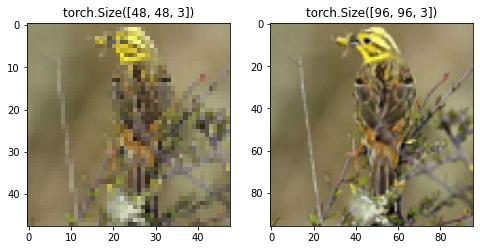

In [ ]:
# 訓練データ（左）と正解データ（右）の確認
fig = plt.figure(figsize=(8,8))
img = np.transpose(x_train[0][0], (1,2,0))
a0 = fig.add_subplot(1,2,1)
a0.set_title('{}'.format(img.shape))
a0.imshow(img)
img = np.transpose(y_train[0][0], (1,2,0))
a1 = fig.add_subplot(1,2,2)
a1.set_title('{}'.format(img.shape))
a1.imshow(img)

In [ ]:
# 画像を表示する関数
def torch_img(torch_datasets, fig_size, matrix):
    """
    引数
    torch_datasets : torchvision.datasets_ torchvisionのデータセットフォーマット
    fig_size : tuple(height, wight)_ フィールドサイズ
    matrix : tuple（row , column）_ 縦横枚数
    """
    f_h, f_w = fig_size
    row, column = matrix

    fig = plt.figure(figsize=(f_w, f_h))
    img_num = row * column
    for id, trg in enumerate(torch_datasets):
        trg = trg[0].cpu().detach().numpy()
        img = np.transpose(trg, (1, 2, 0))
        a = fig.add_subplot(row, column, id+1)
        a.axis('off')
        a.imshow(img)
        if id == (img_num-1):break

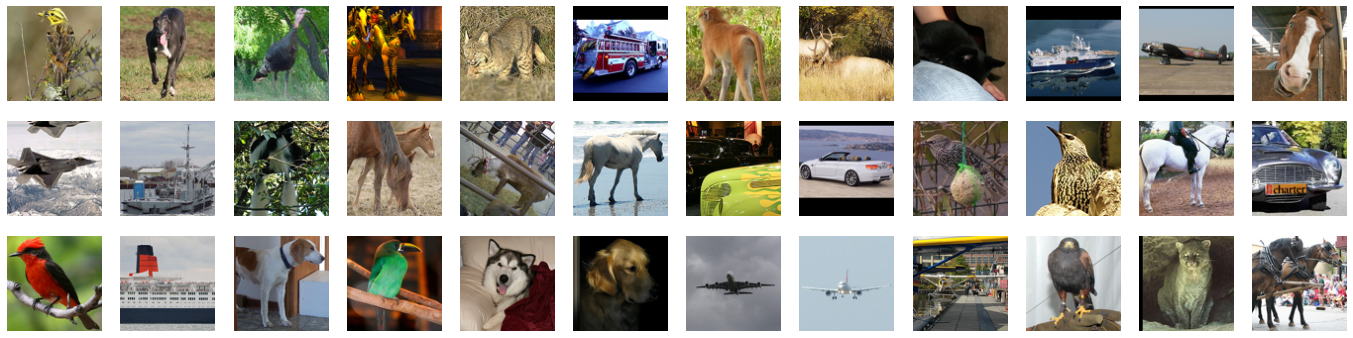

In [ ]:
# 使用する教師データ
fig_size = (6,24)
matrix = (3,12)
torch_img(y_train, fig_size, matrix)

In [ ]:
# 訓練したモデルを呼び出してtorch_img(上記の関数)に使用できるようにする関数
def models_im(path, model, nums, data=x_test):
    """
    引数
    path : str_ モデルの保存先
    model : Module_ 使用するモデルクラス
    nums : int_ 生成画像枚数
    data : torchvision.datasets_ モデルへの入力データ（torchvisionのデータセットフォーマット）
    """
    model = model # 使用するモデルを定義
    model.load_state_dict(torch.load(path, torch.device("cpu"))) # モデルの呼び出し
    model.eval() # テストモードで画像を生成
    model_im = None
    for index in range(10):
        target = torch.unsqueeze(x_test[index][0], 0)
        target= model(target)
        if target.min() < 0:
            target += -torch.min(target) # モデルが負の値を生成した場合の全て正の値になるようシフトする
        target = (target/torch.max(target)) # 画像出力を0-1に正規化(floatのため0-255ではなく0-1)
        if model_im == None:
            model_im = target
        else:
            model_im = torch.concat((model_im, target))
    model_im = torch.unsqueeze(model_im, 1)

    return model_im

## アーキテクチャ
エンコードは (3×48×48) を (512×3×3) に圧縮。<br>
フィルターは3、パディングは1、ストライドは2。<br>
デコードでは (512×3×3) を (3×96×96) へ拡大。<br>
デーコード時のフィルターは4。<br>
デコード時とサイズが同じになるように圧縮と拡張を行い、<br>
スキップ構造でエンコード時の情報をデコード層に和を取る形で受け渡す.


In [ ]:
from torch.functional import Tensor
class Model(nn.Module):


    def __init__(self, hidden_dim):
        """
        引数
        hidden_dim : scaler_ 一層目の出力後のチャネルサイズ(64)
        """
        super(Model, self).__init__()
        stride = 2
        padding = 1
        # エンコーディング・レイヤー
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3, hidden_dim, 3, stride=stride, padding=padding), # 3 -> 64, (48x48) -> (24x24)
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim*2, 3, stride=stride, padding=padding),  # 64 -> 128, (24x24) -> (12x12)
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU()
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(hidden_dim*2, hidden_dim*4, 3, stride=stride, padding=padding), # 128 -> 256, (12x12) -> (6x6)
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU()
        )
        self.layer_4 = nn.Sequential(
            nn.Conv2d(hidden_dim*4, hidden_dim*8, 3, stride=stride, padding=padding), # 256 -> 512, (6x6) -> (3x3)
            nn.BatchNorm2d(hidden_dim*8),
            nn.ReLU()   
        )

        # デコーディング・レイヤー
        self.layer_5 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*8, hidden_dim*4, 4, stride=stride, padding=padding),  # 512 -> 256, (3x3) -> (6x6)
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU()
        )
        self.layer_6 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, 4, stride=stride, padding=padding), # 256 -> 128, (6x6) -> (12x12)
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU()
        )
        self.layer_7 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, stride=stride, padding=padding), # 128 -> 64, (12x12) -> (24x24)
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )
        self.layer_8 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, int(hidden_dim/2), 4, stride=stride, padding=padding), # 64 -> 32, (24x24) -> (48x48)
            nn.BatchNorm2d(int(hidden_dim/2)),
            nn.ReLU()
        )
        self.layer_9 = nn.Sequential(
            nn.ConvTranspose2d(int(hidden_dim/2), 3, 4, stride=stride, padding=padding), # 32 -> 3, (48x48) -> (96x96)
            nn.BatchNorm2d(3)
        )

        self.encode_sequence = [self.layer_1, self.layer_2, self.layer_3, self.layer_4]
        self.decode_sequence = [self.layer_5, self.layer_6, self.layer_7, self.layer_8, self.layer_9]


    def forward(self, x:Tensor) -> Tensor:
        """
        引数
        x : [N, C, H, W]_ 入力データ[バッチサイズ, チャネル数, 高さ, 幅]
        """
        encoded_layer = []
        for en in self.encode_sequence:
            x = en(x)
            encoded_layer.append(x)
        for de in self.decode_sequence:
            if encoded_layer != []:
                x = x + encoded_layer[len(encoded_layer) - 1]
                del(encoded_layer[len(encoded_layer) - 1])
            x = de(x)

        return x

## モデルの学習
損失関数はMSEを使用する.<br>
モデルの成長度合いを目視的に確認するため5エポックごとにモデルを保存する。<br>
今回は20エポックまで。

In [ ]:
num_epochs = 20
batch_size = 100
learning_rate = 1e-3
saving = True

# upsamperで設定した枚数をバッチサイズで分割
x_trains = DataLoader(x_train, batch_size=batch_size)
y_trains = DataLoader(y_train, batch_size=batch_size)

x_tests = DataLoader(x_test, batch_size=batch_size)
y_tests = DataLoader(y_test, batch_size=batch_size)

loss_list = []
loss_test = []
# モデルの定義
model = Model(hidden_dim=64).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 学習
for epoch in range(num_epochs):
    for data in zip(x_trains, y_trains, x_tests, y_tests):
        # 訓練
        model.train() 
        target = torch.Tensor(data[0][0]).to(device)
        out_put = model(target)
        loss = criterion(out_put, data[1][0].to(device))

        loss_list.append(float(loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # テスト        
        model.eval()
        target = torch.Tensor(data[2][0]).to(device)
        out_put = model(target)

        test_loss = criterion(out_put, data[3][0].to(device))
        loss_test.append(float(test_loss))

    print("epoch : ", str(epoch + 1), " | test_loss : ", str(test_loss))
    # モデルの保存(5epochごと)
    if saving == True:
        if (epoch+1)%5==0:
            model_path = 'models/skip_ae/(epoch:{}, batch_size:{}).pth'.format(str(epoch + 1), str(batch_size))
            torch.save(model.state_dict(), model_path)

# lossリストの保存
if saving == True:
    with open('loss_list/train_loss(skip_ae, epoch:{}, batch_size:{}).pickle'.format(str(num_epochs), str(batch_size)), mode='wb') as f:
        pickle.dump(loss_list, f)
    with open('loss_list/train_loss(skip_ae(test), epoch:{}, batch_size:{}).pickle'.format(str(num_epochs), str(batch_size)), mode='wb') as f:
        pickle.dump(loss_test, f)

epoch :  1  | test_loss :  tensor(0.4793, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  2  | test_loss :  tensor(0.5190, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  3  | test_loss :  tensor(0.4426, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  4  | test_loss :  tensor(0.3676, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  5  | test_loss :  tensor(0.3046, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  6  | test_loss :  tensor(0.2530, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  7  | test_loss :  tensor(0.2102, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  8  | test_loss :  tensor(0.1743, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  9  | test_loss :  tensor(0.1439, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  10  | test_loss :  tensor(0.1184, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  11  | test_loss :  tensor(0.0970, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  12  | test_loss :  tensor(0.0791

## 画像の生成
テストデータを使用して5エポックから20エポックまでの過程を確認する。<br>
１行目から順に5, 10, 15, 20エポックの訓練を行なった各モデルの生成画像。

In [ ]:
models = [None]*4
for i in range(5, 21, 5):
    path = "models/skip_ae/(epoch:{}, batch_size:100).pth".format(i)
    model = Model(64)
    model_im = models_im(path, model, 10)
    models[int(i/5-1)] = model_im

fig_size = (6,60)
matrix = (1,10)
for trg in models:
    torch_img(trg, fig_size, matrix)

Output hidden; open in https://colab.research.google.com to view.

５エポックで既に画像の特徴を捉えている。２０エポックにかけて大きな変化は見えないが、３列目の犬の画像では5エポック目の画像に少しノイズのようなものがある。20エポック目ではノイズのような模様は消えている。学習は少しづつだが進んでいるようだ。<br><br>
以下は入力画像（1行目）と20エポックでの生成画像(2行目)と正解画像（3行目）。<br>

In [ ]:
path = "models/skip_ae/(epoch:20, batch_size:100).pth"
model = Model(64)
model_im = models_im(path, model, 10)

torch_img(x_test, fig_size, matrix)
torch_img(model_im, fig_size, matrix)
torch_img(y_test, fig_size, matrix)

Output hidden; open in https://colab.research.google.com to view.

生成された画像では入力画像のジャギーが消えていて正解画像に近づいている。<br>
正解データに比べると解像度は荒いが解像度が上がっていると見てとれる。

## 損失について
以下は20エポックにおける訓練時のロスとテスト時のロス。

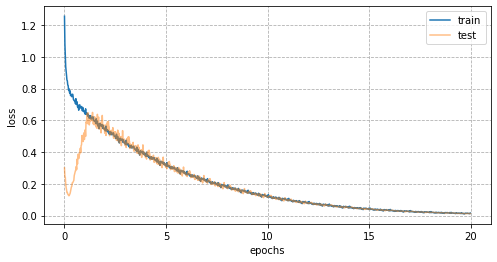

In [ ]:
with open('loss_list/train_loss(skip_ae, epoch:20, batch_size:100).pickle', mode='rb') as f:
    train_loss = pickle.load(f)
with open('loss_list/train_loss(skip_ae(test), epoch:20, batch_size:100).pickle', mode='rb') as f:
    test_loss = pickle.load(f)
plt.figure(figsize=(8,4))
plt.plot(train_loss, label="train", alpha=1)
plt.plot(test_loss, label="test", alpha=0.5)
plt.grid(linestyle="--")
plt.xticks([0, 250, 500, 750, 1000], [0, 5, 10, 15, 20])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

訓練時のロスは大きく振動することなく学習が収束している。<br>
対してテストロスでは初期に一度減少した落ち1,2エポック付近で訓練ロスと同じ値付近まで上昇し周辺で振動している。<br>
その振動も10エポック以降は見られず、テストロスをみる限り過学習は起きてないように見える。<br>

## 今後のについて
ロスに関するグラフをみる限りエポック数を増やしても学習は進みそうではある。<br>
ただ生成された15エポックの画像と20エポックの画像をみる限り違いがあまりわからない。<br>
劇的に正解画像へ近づけるためにはアーキテクチャなどの手法を改善する必要があるようだ。<br>